In [38]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [40]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

In [41]:
# Load data
train = pd.read_csv('../public_data_test/track_a/train/eng.csv')
val = pd.read_csv('../public_data_test/track_a/dev/eng.csv')
test = pd.read_csv('../public_data_test/track_a/test/eng.csv')

# Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [42]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [43]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [44]:
emolex_path = "../NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [45]:
def load_emolex(emolex_path):
    emolex = pd.read_csv(emolex_path, sep='\t', header=None, names=["Word", "Emotion", "Association"])
    # Filter to only include our target emotions
    emolex = emolex[emolex['Emotion'].isin(emotions)]
    
    emotion_dict = {}
    for _, row in emolex.iterrows():
        if row["Association"] == 1:  # Only positive associations
            word = row["Word"].lower()  # Convert to lowercase
            emotion = row["Emotion"].lower()
            if word not in emotion_dict:
                emotion_dict[word] = []
            emotion_dict[word].append(emotion)
    
    print(f"Loaded {len(emotion_dict)} words from EmoLex")
    return emotion_dict

emotion_dict = load_emolex(emolex_path)

Loaded 3155 words from EmoLex


In [46]:
nlp = spacy.load("en_core_web_sm")

# Initialize emotion_matches globally before preprocessing
emotion_matches = {emotion: 0 for emotion in emotions}

for emotion in emotions:
    emotion_words = [word for word, emots in emotion_dict.items() if emotion in emots]
    print(f"\n{emotion} words in lexicon: {len(emotion_words)}")
    print("Sample words:", emotion_words[:5])

# During preprocessing
def pre_process(text, config, target_emotion, emotion_dict):
    global emotion_matches  # Reference the global variable
    
    original_text = text  # Save original text for EmoLex matching

    # First do EmoLex matching on original text
    emolex_words = []
    if target_emotion and emotion_dict:
        # Convert text to lowercase for matching
        text_lower = original_text.lower()
        # Find words that appear in both text and emotion lexicon
        text_words = set(text_lower.split())
        emolex_words = [word for word in text_words 
                       if word in emotion_dict 
                       and target_emotion in emotion_dict[word]]
        
        if emolex_words:
            emotion_matches[target_emotion] += 1

    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    processed_text = " ".join(tokens)

    # Finally, append EmoLex words if found
    if emolex_words:
        processed_text = f"{processed_text} [SEP] {' '.join(emolex_words)}"
    else:
        processed_text = f"{processed_text} [SEP]"
    
    return processed_text

# After preprocessing
print("\nEmotion word matches in training data:")
for emotion in emotions:
    print(f"{emotion}: {emotion_matches[emotion]} texts")


joy words in lexicon: 687
Sample words: ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment']

sadness words in lexicon: 1187
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abortion']

surprise words in lexicon: 532
Sample words: ['abandonment', 'abduction', 'abrupt', 'accident', 'accidental']

fear words in lexicon: 1474
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abhor']

anger words in lexicon: 1245
Sample words: ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish']

Emotion word matches in training data:
joy: 0 texts
sadness: 0 texts
surprise: 0 texts
fear: 0 texts
anger: 0 texts


In [47]:
# Vectorizer Definition
vectorizer = CountVectorizer()

In [48]:
# Reset emotion_matches before processing dataset
def preprocess_dataset_with_emotions(dataset, emotions, config, emotion_dict):
    global emotion_matches
    emotion_matches = {emotion: 0 for emotion in emotions}  # Reset counters
    
    augmented_data = {}
    
    # Process for each emotion
    for emotion in emotions:
        print(f"\nProcessing {emotion}:")
        texts = []
        for text in tqdm(dataset):
            processed = pre_process(text, config, target_emotion=emotion, emotion_dict=emotion_dict)
            texts.append(processed)
            
        # Count how many texts contain emotion-specific words
        emotion_word_count = sum(1 for text in texts if '[SEP]' in text and not text.endswith('[SEP]'))
        print(f"Texts with {emotion}-specific words: {emotion_matches[emotion]}/{len(texts)}")
        
        augmented_data[emotion] = texts
    
    return augmented_data

train_augmented = preprocess_dataset_with_emotions(train["text"], emotions, config, emotion_dict)
val_augmented = preprocess_dataset_with_emotions(val["text"], emotions, config, emotion_dict)
test_augmented = preprocess_dataset_with_emotions(test["text"], emotions, config, emotion_dict)

# Fit the vectorizer on the combined training data
vectorizer = CountVectorizer()
vectorizer.fit(train_augmented['joy'] + train_augmented['sadness'] + train_augmented['surprise'] + train_augmented['fear'] + train_augmented['anger'])

# Transform each emotion separately
X_train = {emotion: vectorizer.transform(train_augmented[emotion]).toarray() for emotion in emotions}
X_val = {emotion: vectorizer.transform(val_augmented[emotion]).toarray() for emotion in emotions}
X_test = {emotion: vectorizer.transform(test_augmented[emotion]).toarray() for emotion in emotions}


Processing joy:


100%|██████████| 2768/2768 [00:01<00:00, 1941.10it/s]


Texts with joy-specific words: 461/2768

Processing sadness:


100%|██████████| 2768/2768 [00:01<00:00, 1988.94it/s]


Texts with sadness-specific words: 569/2768

Processing surprise:


100%|██████████| 2768/2768 [00:01<00:00, 2054.32it/s]


Texts with surprise-specific words: 318/2768

Processing fear:


100%|██████████| 2768/2768 [00:01<00:00, 2063.66it/s]


Texts with fear-specific words: 520/2768

Processing anger:


100%|██████████| 2768/2768 [00:01<00:00, 1826.84it/s]


Texts with anger-specific words: 463/2768

Processing joy:


100%|██████████| 116/116 [00:00<00:00, 1817.30it/s]


Texts with joy-specific words: 19/116

Processing sadness:


100%|██████████| 116/116 [00:00<00:00, 1898.44it/s]


Texts with sadness-specific words: 22/116

Processing surprise:


100%|██████████| 116/116 [00:00<00:00, 1926.52it/s]


Texts with surprise-specific words: 15/116

Processing fear:


100%|██████████| 116/116 [00:00<00:00, 1980.88it/s]


Texts with fear-specific words: 21/116

Processing anger:


100%|██████████| 116/116 [00:00<00:00, 1939.54it/s]


Texts with anger-specific words: 17/116

Processing joy:


100%|██████████| 2767/2767 [00:01<00:00, 1980.38it/s]


Texts with joy-specific words: 453/2767

Processing sadness:


100%|██████████| 2767/2767 [00:01<00:00, 1981.33it/s]


Texts with sadness-specific words: 537/2767

Processing surprise:


100%|██████████| 2767/2767 [00:01<00:00, 1968.10it/s]


Texts with surprise-specific words: 349/2767

Processing fear:


100%|██████████| 2767/2767 [00:01<00:00, 1999.99it/s]


Texts with fear-specific words: 531/2767

Processing anger:


100%|██████████| 2767/2767 [00:01<00:00, 1814.83it/s]


Texts with anger-specific words: 438/2767


In [49]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu
/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [50]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [51]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [52]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [53]:
# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

In [55]:
# Get BERT embeddings for training data
print("Getting training BERT embeddings...")
train_raw_preds = get_predictions_batch(train['text'].tolist())
train_bert_features = format_predictions(train_raw_preds, emotion_mapping)

print("Getting validation BERT embeddings...")
val_raw_preds = get_predictions_batch(val['text'].tolist())
val_bert_features = format_predictions(val_raw_preds, emotion_mapping)

print("Getting test BERT embeddings...")
test_raw_preds = get_predictions_batch(test['text'].tolist())
test_bert_features = format_predictions(test_raw_preds, emotion_mapping)

# Get POS features
print("Extracting POS features...")
train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])
test_pos_tags = extract_pos_tags(test["text"])

# POS Encoding
max_length = max(
    max(len(tags) for tags in train_pos_tags),
    max(len(tags) for tags in val_pos_tags),
    max(len(tags) for tags in test_pos_tags)
)
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]
test_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in test_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)
test_pos_encoded = encoder.transform(test_pos_tags)

Getting training BERT embeddings...


Predicting: 100%|██████████| 87/87 [03:22<00:00,  2.32s/it]


Getting validation BERT embeddings...


Predicting: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Getting test BERT embeddings...


Predicting: 100%|██████████| 87/87 [03:11<00:00,  2.20s/it]


Extracting POS features...


In [56]:
# Combine features for each emotion separately
final_train_features = {}
final_val_features = {}
final_test_features = {}

print("Combining features for each emotion...")
for emotion in emotions:
    print(f"\nProcessing {emotion}:")
    print(f"X_train shape: {X_train[emotion].shape}")
    print(f"train_bert_features shape: {train_bert_features.shape}")
    print(f"train_pos_encoded shape: {train_pos_encoded.shape}")
    
    final_train_features[emotion] = np.hstack([
        X_train[emotion],
        train_bert_features,
        train_pos_encoded
    ])
    
    final_val_features[emotion] = np.hstack([
        X_val[emotion],
        val_bert_features,
        val_pos_encoded
    ])
    
    final_test_features[emotion] = np.hstack([
        X_test[emotion],
        test_bert_features,
        test_pos_encoded
    ])
    
    print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

Combining features for each emotion...

Processing joy:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for joy: (2768, 5521)

Processing sadness:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for sadness: (2768, 5521)

Processing surprise:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for surprise: (2768, 5521)

Processing fear:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for fear: (2768, 5521)

Processing anger:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for anger: (2768, 5521)


In [57]:
# # Create a model for each emotion
# models = {}
# for emotion in emotions:
#     input_size = final_train_features[emotion].shape[1]  # Get the feature size for each emotion
#     models[emotion] = nn.Sequential(
#         nn.Linear(input_size, 256),  # Use the correct input size
#         nn.BatchNorm1d(256),
#         nn.ReLU(),
#         nn.Dropout(0.3),
#         nn.Linear(256, 128),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(128, 64),
#         nn.BatchNorm1d(64),
#         nn.ReLU(),
#         nn.Linear(64, 1)
#     )

In [58]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [59]:
for emotion in emotions:

    print(f"Feature size for {emotion}: {final_train_features[emotion].shape[1]}")

Feature size for joy: 5521
Feature size for sadness: 5521
Feature size for surprise: 5521
Feature size for fear: 5521
Feature size for anger: 5521


In [60]:
import torch
import torch.nn.functional as F

def add_adversarial_noise(model, inputs, labels, epsilon=0.01):
    # Set requires_grad attribute of tensor to True
    inputs.requires_grad = True

    # Forward pass
    outputs = model(inputs)
    loss = F.binary_cross_entropy_with_logits(outputs, labels)

    # Backward pass to calculate gradients
    model.zero_grad()
    loss.backward()

    # Collect the gradients of the inputs
    data_grad = inputs.grad.data

    # Create adversarial examples by adding perturbation
    perturbed_data = inputs + epsilon * data_grad.sign()

    # Return the perturbed data
    return perturbed_data

In [61]:
# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

In [66]:
!pip install optuna
import optuna
from sklearn.metrics import f1_score

DEPRECATION: Loading egg at /Users/angwang/miniforge3/lib/python3.12/site-packages/huggingface_hub-0.27.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# import torch
# from sklearn.metrics import f1_score

# def evaluate_model(model, data_loader, device):
#     model.eval()  # Set the model to evaluation mode
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():  # Disable gradient calculation
#         for features, labels in data_loader:
#             features, labels = features.to(device), labels.to(device)
#             outputs = model(features)
#             preds = torch.sigmoid(outputs).squeeze().cpu().numpy()  # Convert logits to probabilities
#             all_preds.extend(preds)
#             all_labels.extend(labels.cpu().numpy())

#     # Convert predictions to binary using a threshold (e.g., 0.5)
#     binary_preds = (np.array(all_preds) > 0.5).astype(int)
#     macro_f1 = f1_score(all_labels, binary_preds, average='macro', zero_division=0)

#     return macro_f1

In [76]:
import optuna
import torch
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import f1_score
import logging

logging.basicConfig(level=logging.INFO)

# Initialize dictionaries to store best hyperparameters and thresholds for each emotion
best_hyperparams = {emotion: None for emotion in emotions}
best_thresholds = {emotion: 0.5 for emotion in emotions}
best_macro_f1s = {emotion: 0 for emotion in emotions}

# Initialize a global dictionary to store the best model state dicts
best_model_state_dicts = {}

# Update model architecture with current dropout rate
models = {}

# Iterate over all combinations of hyper-parameters
# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    lr = 1e-3 #trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = 32 #trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)

    scaler = GradScaler()
    
    for emotion in emotions:
        input_size = final_train_features[emotion].shape[1]
        models[emotion] = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    # Training loop for each emotion
    # best_macro_f1 = 0
    for emotion in emotions:
        print(f"\nTraining model for {emotion}")
        model = models[emotion]
        model.train()  # Add this to explicitly set training mode
        
        # Prepare data for this emotion
        features_tensor = torch.tensor(final_train_features[emotion], dtype=torch.float32)
        labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
        
        # Add validation tensors
        val_features_tensor = torch.tensor(final_val_features[emotion], dtype=torch.float32)
        val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
        print(f"Validation features shape for {emotion}: {val_features_tensor.shape}")
        
        dataset = TensorDataset(features_tensor, labels_tensor)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Increased batch size

        # Calculate class weights for this emotion
        pos_weight = (len(labels_tensor) - labels_tensor.sum()) / labels_tensor.sum()
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Better handling of class imbalance
        
        # Use Adam optimizer with learning rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

        # Determine the device to use
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Training loop
        best_f1 = 0
        patience = 10
        patience_counter = 0
        train_losses = []
        val_f1s = []
        
        for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})", unit="epoch"):
            # Training phase
            model.train()
            epoch_loss = 0
            batch_count = 0
            
            for features, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{401} Batches", leave=False, unit="batch"):
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast():
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Forward pass for original data
                outputs = model(features)
                loss = criterion(outputs, labels)

                # Generate adversarial examples
                adv_features = add_adversarial_noise(model, features, labels)

                # Forward pass for adversarial examples
                adv_outputs = model(adv_features)
                adv_loss = criterion(adv_outputs, labels)

                # Combine losses
                total_loss = loss + adv_loss

                # Backward pass and optimize
                total_loss.backward()
                optimizer.step()

                epoch_loss += total_loss.item()
                batch_count += 1

            avg_train_loss = epoch_loss / batch_count
            train_losses.append(avg_train_loss)  # Append average training loss
            
            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(val_features_tensor)
                val_probs = torch.sigmoid(val_outputs).squeeze().numpy()  # Convert to probabilities
                val_labels = val_labels_tensor.squeeze().numpy()
                
                # Calculate macro F1 score using a default threshold (e.g., 0.5)
                val_preds = (val_probs > 0.5).astype(float)
                macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
                trial.report(macro_f1, epoch)

                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

                val_f1s.append(macro_f1)  # Append validation F1 score
                
                if macro_f1 > best_f1:
                    best_f1 = macro_f1
                    # Save best model
                    model_path = f'./model_checkpoints/{emotion}_best.pth'
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': avg_train_loss,
                        'f1': best_f1
                    }, model_path)
                    # Save best model state dict to the global dictionary
                    best_model_state_dicts[emotion] = model.state_dict()
                    print(f"\nNew best model for {emotion} at epoch {epoch} with F1: {best_f1:.4f}")
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # # Update the learning rate based on the validation F1 score
                scheduler.step(macro_f1)

            # Early stopping
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                break
                        # Check if this is the best macro F1 score

        # Load best model for this emotion
        checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nLoaded best model for {emotion} from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")

        model.load_state_dict(best_model_state_dicts[emotion])
        print(f"\nLoaded best model for {emotion} with F1: {best_f1:.4f}")

        # Update the global models dictionary with the best model
        models[emotion] = model

        # Load best model state dict from the global dictionary
        model.load_state_dict(best_model_state_dicts[emotion])
        print(f"\nLoaded best model for {emotion} with F1: {best_f1:.4f}")

        # Optimize threshold after training
        print(f"\nOptimizing threshold for {emotion}...")
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_probs = torch.sigmoid(val_outputs).squeeze().numpy()
            val_labels = val_labels_tensor.squeeze().numpy()
            
            # Perform threshold grid search
            thresholds = np.arange(0.1, 0.9, 0.05)
            best_threshold = 0.5
            best_macro_f1 = 0
            
            for threshold in thresholds:
                val_preds = (val_probs > threshold).astype(float)
                macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
                
                if macro_f1 > best_macro_f1:
                    best_macro_f1 = macro_f1
                    best_threshold = threshold
            
            print(f"Best threshold for {emotion}: {best_threshold:.2f} with Macro F1: {best_macro_f1:.4f}")
        
        if best_f1 > best_macro_f1s[emotion]:
            best_macro_f1s[emotion] = best_macro_f1
            best_thresholds[emotion] = best_threshold
            best_hyperparams[emotion] = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay
            }
            
        # Plot training curves
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
        plt.title(f'Training Loss for {emotion}')
        plt.xlabel('Epoch (x10)')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
        plt.title(f'Validation Macro F1 for {emotion}')
        plt.xlabel('Epoch (x10)')
        plt.ylabel('Macro F1')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Report intermediate results to Optuna
        trial.report(macro_f1, epoch)

        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return sum(best_macro_f1s.values()) / len(emotions)  # Return average macro F1

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=4)  # Run 4 trials in parallel

for emotion in emotions:
    print(f"\nBest hyperparameters for {emotion}: {best_hyperparams[emotion]}")
    print(f"Best threshold for {emotion}: {best_thresholds[emotion]:.3f} with Macro F1: {best_macro_f1s[emotion]:.4f}")

# After the study, you can access the best models from the global dictionary
for emotion in emotions:
    print(f"\nBest model state dict for {emotion}: {best_model_state_dicts[emotion]}")
    # Ensure the models dictionary is updated with the best model
    models[emotion].load_state_dict(best_model_state_dicts[emotion])

[I 2025-01-31 18:42:55,580] A new study created in memory with name: no-name-45a93e24-8e53-4f45-8122-946ce69869a8
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_18361/3394097622.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_18361/3394097622.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_18361/3394097622.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', ar


Training model for joy

Training model for joy

Training model for joy

Training model for joy
Validation features shape for joy: torch.Size([116, 5521])
Validation features shape for joy: torch.Size([116, 5521])
Validation features shape for joy: torch.Size([116, 5521])
Validation features shape for joy: torch.Size([116, 5521])


/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(





/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_18361/3394097622.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(





































































Training Loop (joy):   0%|          | 0/401 [00:02<?, ?epoch/s]
[W 2025-01-31 18:42:58,390] Trial 0 failed with parameters: {'dropout_rate': 0.20624912559169276, 'weight_decay': 1.8156231416453193e-05} because of the following error: RuntimeError('Tensor for argument input is on cpu but expected on mp

KeyboardInterrupt: 

Previous F1 scores for each emotion before threshold tuning and hyperparameter search:

Here are the macro f1 scores for each emotion: 

Using best joy model from epoch 10 with F1: 0.727
Using best sadness model from epoch 12 with F1: 0.789
Using best surprise model from epoch 7 with F1: 0.733
Using best fear model from epoch 6 with F1: 0.714
Using best anger model from epoch 3 with F1: 0.728

Final average macro f1 be 0.62?

### Complete same training loop for all emotions using macro F1 score

In [25]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

### Run Final Models and make final predictions for submission


Generating predictions for all emotions...
Using best joy model from epoch 10 with F1: 0.727


/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_18361/184351224.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoints

Using best sadness model from epoch 12 with F1: 0.789
Using best surprise model from epoch 7 with F1: 0.733
Using best fear model from epoch 6 with F1: 0.714
Using best anger model from epoch 3 with F1: 0.728

Performing threshold grid search...


Testing thresholds:   0%|          | 0/16 [00:00<?, ?it/s]/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Testing thresholds:  25%|██▌       | 4/16 [00:00<00:00, 38.84it/s]/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted


Best Results:
Best threshold: 0.500
Best Macro F1: 0.622


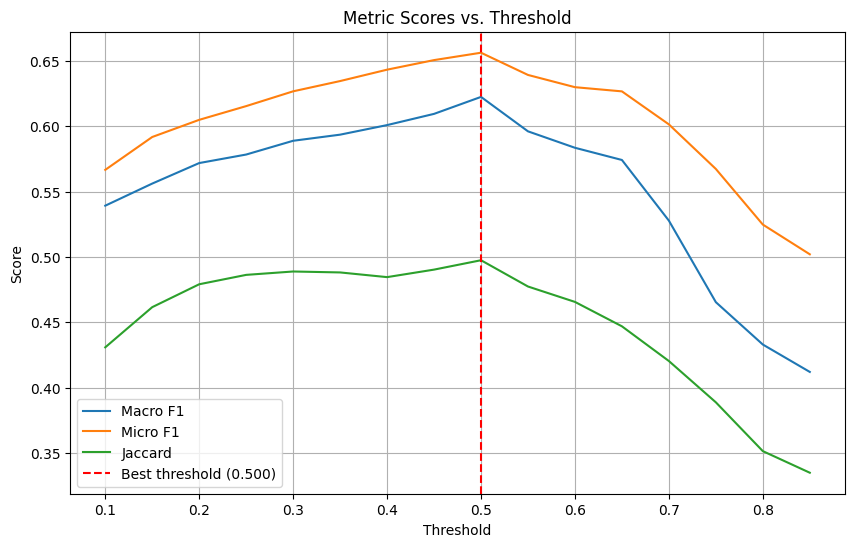


Final Validation Performance with Best Threshold:
              precision    recall  f1-score   support

         joy       0.71      0.48      0.58        31
     sadness       0.81      0.60      0.69        35
    surprise       0.65      0.55      0.60        31
        fear       0.75      0.71      0.73        63
       anger       0.64      0.44      0.52        16

   micro avg       0.73      0.60      0.66       176
   macro avg       0.71      0.56      0.62       176
weighted avg       0.73      0.60      0.65       176
 samples avg       0.62      0.55      0.56       176

Saved predictions to ../results/val_predictions_threshold_0.500_2025-01-30_19_11_35.csv
Saved predictions to ../results/test_predictions_threshold_0.500_2025-01-30_19_11_35.csv

Per-emotion performance at best threshold:
joy: F1 = 0.577
sadness: F1 = 0.689
surprise: F1 = 0.596
fear: F1 = 0.732
anger: F1 = 0.519


/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# After training loop finishes for all emotions...

# Make predictions for each emotion using best models
print("\nGenerating predictions for all emotions...")
val_preds = {}
test_preds = {}

for emotion in emotions:
    # Load the best model for this emotion
    model = models[emotion]
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"Using best {emotion} model from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.3f}")
    
    with torch.no_grad():
        # Get raw probabilities using sigmoid
        val_outputs = model(torch.tensor(final_val_features[emotion], dtype=torch.float32))
        val_probs = torch.sigmoid(val_outputs).numpy()
        val_preds[emotion] = (val_probs > best_thresholds[emotion]).astype(int)  # Apply threshold
        
        test_outputs = model(torch.tensor(final_test_features[emotion], dtype=torch.float32))
        test_probs = torch.sigmoid(test_outputs).numpy()
        test_preds[emotion] = (test_probs > best_thresholds[emotion]).astype(int)  # Apply threshold

# Combine predictions
val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# Grid search for optimal threshold
# print("\nPerforming threshold grid search...")
# thresholds = np.arange(0.1, 0.9, 0.05)
# best_threshold = 0
# best_macro_f1 = 0
# results = []

# # Calculate metrics
# macro_f1 = f1_score(val[emotions].values, val_probs, average='macro')
# micro_f1 = f1_score(val[emotions].values, val_probs, average='micro')
# jaccard = jaccard_score(val[emotions].values, val_probs, average='samples')

# results.append({
#     'macro_f1': macro_f1,
#     'micro_f1': micro_f1,
#     'jaccard': jaccard
# })

# Generate final predictions using best threshold
# val_binary_preds = (val_probs > best_threshold).astype(int)
# test_binary_preds = (test_probs > best_threshold).astype(int)

# Print detailed performance report
print("\nFinal Validation Performance with Best Threshold:")
print(classification_report(
    val[emotions].values,
    val_probs,
    target_names=emotions
))

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

# Save validation predictions
save_predictions(
    val_probs,
    val['id'],
    f'../results/val_predictions_threshold_{best_thresholds[emotion]:.3f}_{timestamp}.csv'
)

# Save test predictions
save_predictions(
    test_probs,
    test['id'],
    f'../results/test_predictions_threshold_{best_thresholds[emotion]:.3f}_{timestamp}.csv'
)

# for threshold in tqdm(thresholds, desc="Testing thresholds"):
#     # Convert probabilities to binary predictions
#     val_binary_preds = (val_probs > threshold).astype(int)
    
#     # Calculate metrics
#     macro_f1 = f1_score(val[emotions].values, val_binary_preds, average='macro')
#     micro_f1 = f1_score(val[emotions].values, val_binary_preds, average='micro')
#     jaccard = jaccard_score(val[emotions].values, val_binary_preds, average='samples')
    
#     results.append({
#         'threshold': threshold,
#         'macro_f1': macro_f1,
#         'micro_f1': micro_f1,
#         'jaccard': jaccard
#     })
    
#     # Update best threshold if we found better macro F1
#     if macro_f1 > best_macro_f1:
#         best_macro_f1 = macro_f1
        # best_threshold = threshold

# Convert results to DataFrame and display
# results_df = pd.DataFrame(results)
# print("\nBest Results:")
# print(f"Best threshold: {best_threshold:.3f}")
# print(f"Best Macro F1: {best_macro_f1:.3f}")

# Plot the threshold search results
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
# plt.plot(results_df['threshold'], results_df['micro_f1'], label='Micro F1')
# plt.plot(results_df['threshold'], results_df['jaccard'], label='Jaccard')
# plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Metric Scores vs. Threshold')
# plt.legend()
# plt.grid(True)
# plt.show()

# Save threshold search results
# results_df.to_csv(f'../results/threshold_search_results_{timestamp}.csv', index=False)

# Print per-emotion performance
print("\nPer-emotion performance:")
for i, emotion in enumerate(emotions):
    # Calculate F1 score
    emotion_f1 = f1_score(
        val[emotions].values[:, i],
        val_probs[:, i],
        average='binary'
    )
    
    # Calculate Jaccard index
    emotion_jaccard = jaccard_score(
        val[emotions].values[:, i],
        val_probs[:, i],
        average='binary'
    )
    
    print(f"{emotion}: F1 = {emotion_f1:.3f}, Jaccard = {emotion_jaccard:.3f}")

END FOR NOW